In [2]:
# compute cluster energy resolution
import os
import glob
import uproot
import awkward as ak
import pandas as pd
import numpy as np

# locate file and open tree (same as you have)
#root_files = glob.glob("/mnt/nvme0n1p4/HEP/Work/Project-W-Z/MotorHead/quicktree2histo/plot-recoil/outTree.root", recursive=True)
root_files = glob.glob("/mnt/nvme0n1p4/HEP/Work/Project-W-Z/MotorHead/quicktree2histo/plot-recoil/root-files/outTree_zmumu_withPU_merged.root", recursive=True)
#root_files = glob.glob("/mnt/nvme0n1p4/HEP/Work/Project-W-Z/MotorHead/quicktree2histo/plot-recoil/root-files/outTree_zmumu_woPU_merged.root", recursive=True)
file_path = root_files[0]
n_events = 50000
with uproot.open(file_path) as f:
    tree = f["treeAnaWZ"]
    arr = tree.arrays(["fCluster_truthE","fCluster_rawE","fCluster_calE","fCluster_MLE"], library="ak", entry_start=0, entry_stop=n_events)

# sanity check: per-event cluster counts must match
n_truth = ak.num(arr["fCluster_truthE"])
n_raw   = ak.num(arr["fCluster_rawE"])
n_cal   = ak.num(arr["fCluster_calE"])
n_mle   = ak.num(arr["fCluster_MLE"])
if not ak.all((n_truth == n_raw) & (n_truth == n_cal) & (n_truth == n_mle)):
    raise ValueError("Per-event cluster counts differ between branches — do not proceed")

# zip fields so each record keeps its fields together, flatten once, convert to pandas
z = ak.zip({
    "fCluster_truthE": arr["fCluster_truthE"],
    "fCluster_rawE":   arr["fCluster_rawE"],
    "fCluster_calE":   arr["fCluster_calE"],
    "fCluster_MLE":    arr["fCluster_MLE"]
})
flat = ak.flatten(z)               # 1D array, one record per cluster
# Convert to pandas DataFrame. ak.to_pandas may not be available in some
# awkward versions, so use ak.to_list(flat) which returns a list of dicts
# and is compatible with pandas.DataFrame.
df = pd.DataFrame(ak.to_list(flat))  # DataFrame: columns are the fields

# same filtering and derived columns as you already do
mask_valid = np.isfinite(df["fCluster_truthE"]) & (df["fCluster_truthE"] > 0)
df = df.loc[mask_valid].reset_index(drop=True)
df["response_em"] = df["fCluster_rawE"] / df["fCluster_truthE"]
df["response_lc"] = df["fCluster_calE"] / df["fCluster_truthE"]
df["response_ml"] = df["fCluster_MLE"] / df["fCluster_truthE"]

In [9]:
def relative_resolution_68(x):
    median = np.median(x)
    q16 = np.percentile(x, 16)
    q84 = np.percentile(x, 84)
    return (q84 - q16) / (2 * median)


# choose log bins (adjust edges to your energy units)
log_energy_bins = np.logspace(1, 5, 21)  # 20 bins from 10^1 to 10^5
bin_centers = np.sqrt(log_energy_bins[:-1] * log_energy_bins[1:])

resolution_em = []
resolution_lc = []
resolution_ml = []

sigma_em = []
sigma_lc = []
sigma_ml = []

for low, high in zip(log_energy_bins[:-1], log_energy_bins[1:]):
    mask = (df["fCluster_truthE"] >= low) & (df["fCluster_truthE"] < high)
    bin_em = df.loc[mask, "response_em"].to_numpy()
    bin_lc = df.loc[mask, "response_lc"].to_numpy()
    bin_ml = df.loc[mask, "response_ml"].to_numpy()

    # 68% resolution
    sigma_em.append(relative_resolution_68(bin_em))
    sigma_lc.append(relative_resolution_68(bin_lc))
    sigma_ml.append(relative_resolution_68(bin_ml))


# convert to arrays for plotting
bin_centers = np.array(bin_centers)
sigma_em = np.array(sigma_em)
sigma_lc = np.array(sigma_lc)
sigma_ml = np.array(sigma_ml)


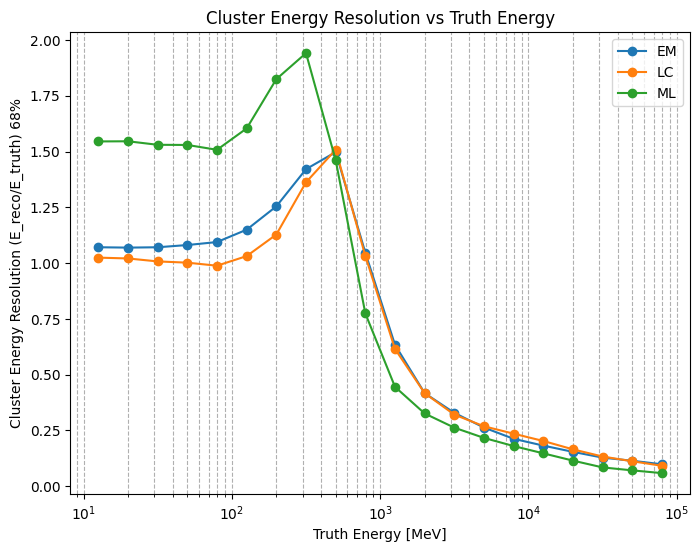

In [10]:
# plot the resolutions
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.semilogx(bin_centers, sigma_em, label='EM', marker='o')
plt.semilogx(bin_centers, sigma_lc, label='LC', marker='o')
plt.semilogx(bin_centers, sigma_ml, label='ML', marker='o')
plt.yscale('linear')  # ensure linear y-axis
plt.xlabel('Truth Energy [MeV]')
plt.ylabel('Cluster Energy Resolution (E_reco/E_truth) 68%')
plt.title('Cluster Energy Resolution vs Truth Energy')
plt.legend()
plt.grid(True, which="both", ls="--", axis='x')
plt.savefig("cluster_energy_resolution.png")
plt.show()

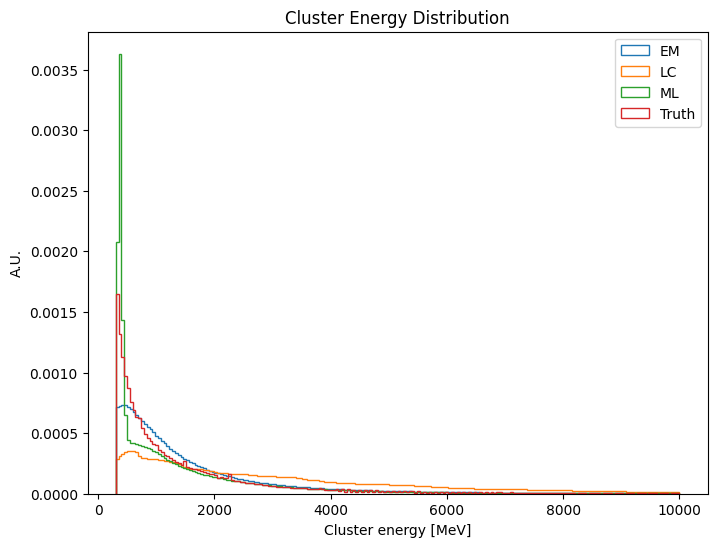

In [11]:
# plot histogram of cluster energy at different scales

min_energy = 300
max_energy = 10000
n_bins = 200


plt.figure(figsize=(8,6))
plt.hist(df["fCluster_rawE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='EM', density=True)
plt.hist(df["fCluster_calE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='LC', density=True)
plt.hist(df["fCluster_MLE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='ML', density=True)
plt.hist(df["fCluster_truthE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='Truth', density=True)
#plt.yscale('log')
plt.xlabel('Cluster energy [MeV]')
plt.ylabel('A.U.')
plt.title('Cluster Energy Distribution')
plt.legend()
#plt.yscale('log')
#plt.xscale('log')
#plt.grid(True, which="both", ls="--", axis='x')
plt.savefig("cluster_energy_distribution.png")
plt.show()



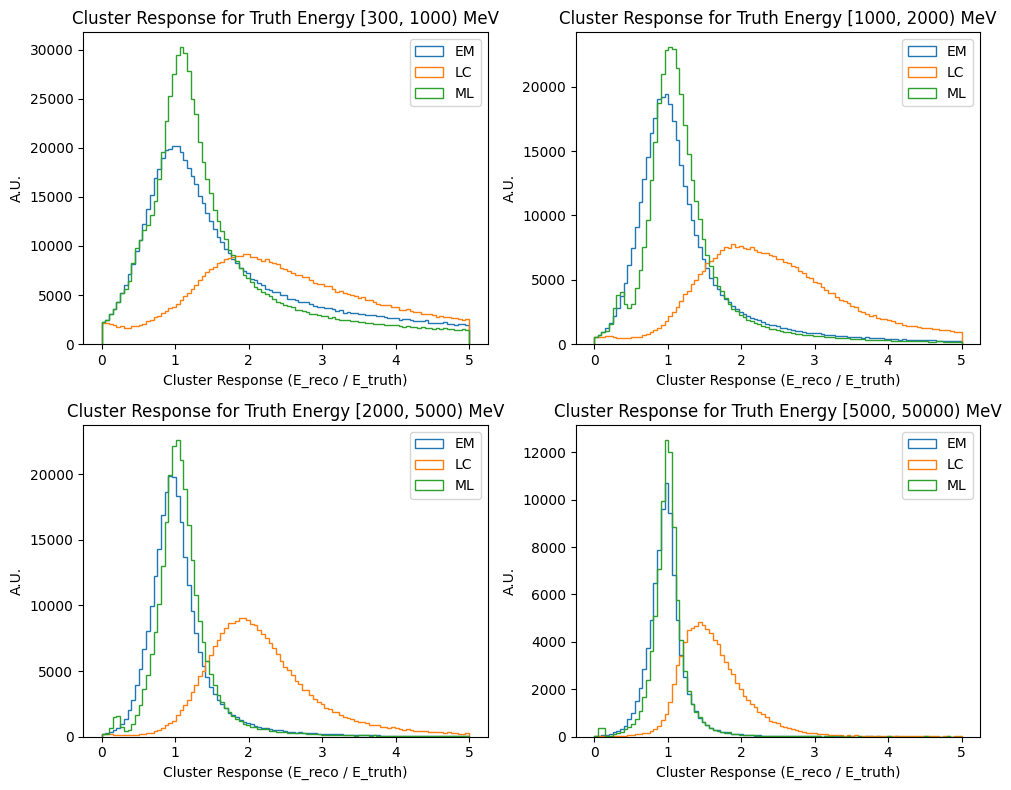

In [12]:
## plot cluster response (E_reco / E_truth) histograms at different energy slices
# use finer binning of 50 MeV
energy_slices = [(300, 1000), (1000, 2000), (2000, 5000), (5000, 50000)]
#energy_slices = [(0, 50000)]
bins_response = np.linspace(0, 5, 100)  # finer bins for response
plt.figure(figsize=(10, 8))
for i, (low, high) in enumerate(energy_slices):
    mask = (df["fCluster_truthE"] >= low) & (df["fCluster_truthE"] < high)
    plt.subplot(2, 2, i+1)
    plt.hist(df.loc[mask, "response_em"], bins=bins_response, histtype='step', label='EM')#, density=True)
    plt.hist(df.loc[mask, "response_lc"], bins=bins_response, histtype='step', label='LC')#, density=True)
    plt.hist(df.loc[mask, "response_ml"], bins=bins_response, histtype='step', label='ML')#, density=True)
    plt.xlabel('Cluster Response (E_reco / E_truth)')
    plt.ylabel('A.U.')
    plt.title(f'Cluster Response for Truth Energy [{low}, {high}) MeV')
    plt.legend()
plt.tight_layout()
plt.savefig("cluster_response_slices_1.png")
plt.show()

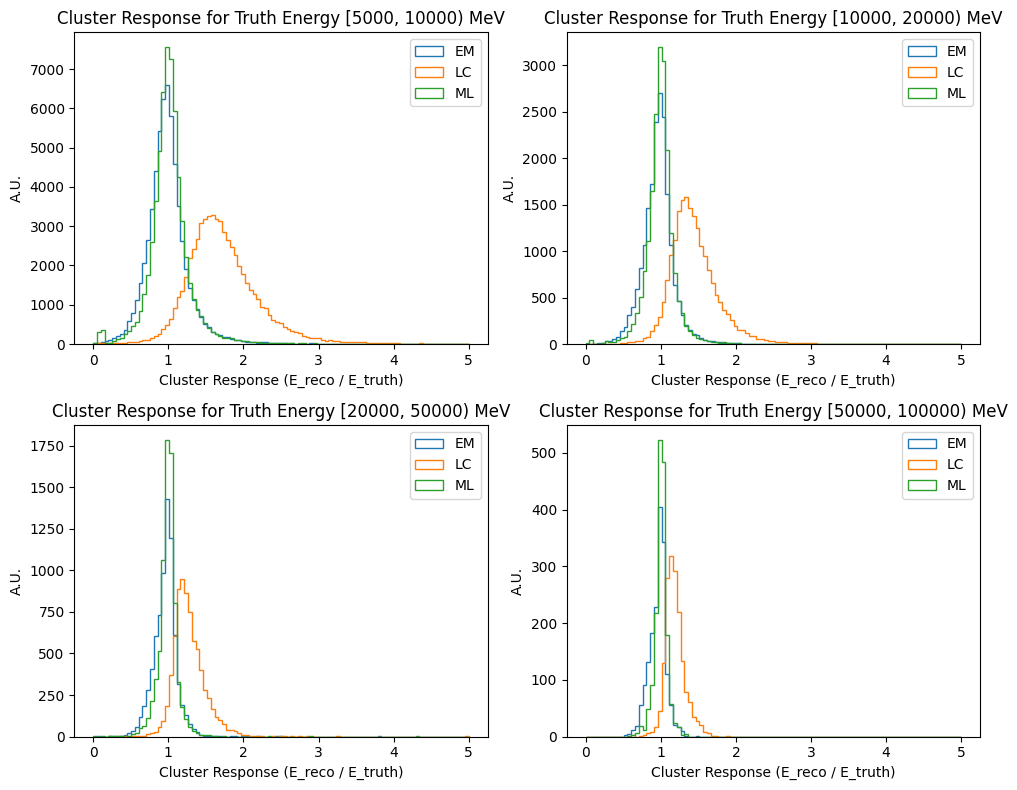

In [13]:
# more plots 
# use finer binning of 50 MeV
energy_slices = [(5000, 10000), (10000, 20000), (20000, 50000), (50000, 100000)]
#energy_slices = [(0, 50000)]
bins_response = np.linspace(0, 5, 100)  # finer bins for response
plt.figure(figsize=(10, 8))
for i, (low, high) in enumerate(energy_slices):
    mask = (df["fCluster_truthE"] >= low) & (df["fCluster_truthE"] < high)
    plt.subplot(2, 2, i+1)
    plt.hist(df.loc[mask, "response_em"], bins=bins_response, histtype='step', label='EM')#, density=True)
    plt.hist(df.loc[mask, "response_lc"], bins=bins_response, histtype='step', label='LC')#, density=True)
    plt.hist(df.loc[mask, "response_ml"], bins=bins_response, histtype='step', label='ML')#, density=True)
    plt.xlabel('Cluster Response (E_reco / E_truth)')
    plt.ylabel('A.U.')
    plt.title(f'Cluster Response for Truth Energy [{low}, {high}) MeV')
    plt.legend()
plt.tight_layout()
plt.savefig("cluster_response_slices_2.png")
plt.show()

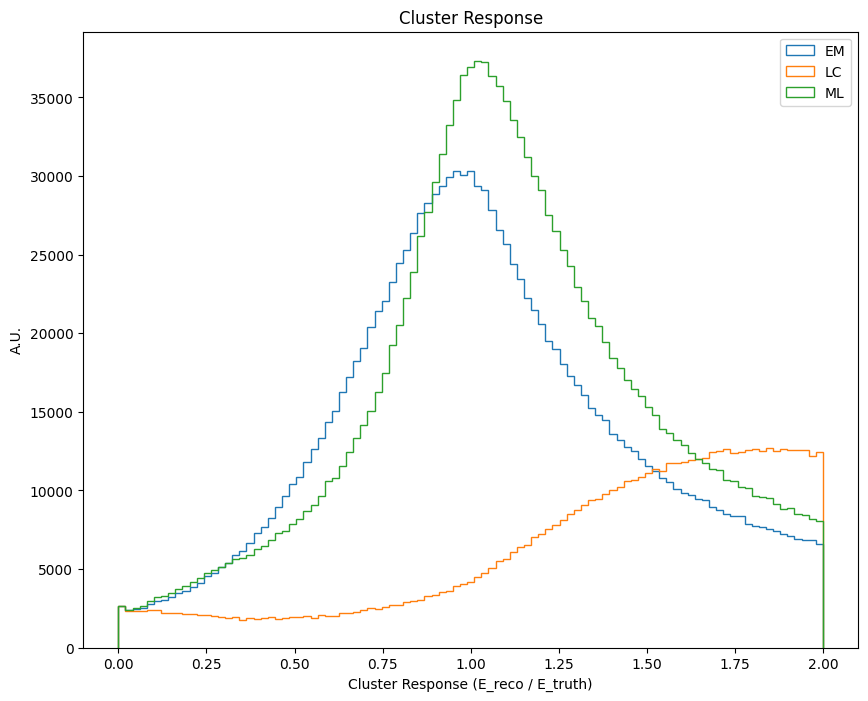

In [14]:
## plot cluster response (E_reco / E_truth) histograms at different energy slices
# use finer binning of 50 MeV
bins_response = np.linspace(0, 2, 100)  # finer bins for response
plt.figure(figsize=(10, 8))
low = 0
high = 50000
mask = (df["fCluster_truthE"] >= low) & (df["fCluster_truthE"] < high)
plt.hist(df.loc[mask, "response_em"], bins=bins_response, histtype='step', label='EM')#, density=True)
plt.hist(df.loc[mask, "response_lc"], bins=bins_response, histtype='step', label='LC')#, density=True)
plt.hist(df.loc[mask, "response_ml"], bins=bins_response, histtype='step', label='ML')#, density=True)
plt.xlabel('Cluster Response (E_reco / E_truth)')
plt.ylabel('A.U.')
plt.title(f'Cluster Response')
plt.legend()
plt.savefig("cluster_response.png")
plt.show()